C:\Users\SHUBH\AppData\Local\Temp\ipykernel_12736\2057434194.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(graph)


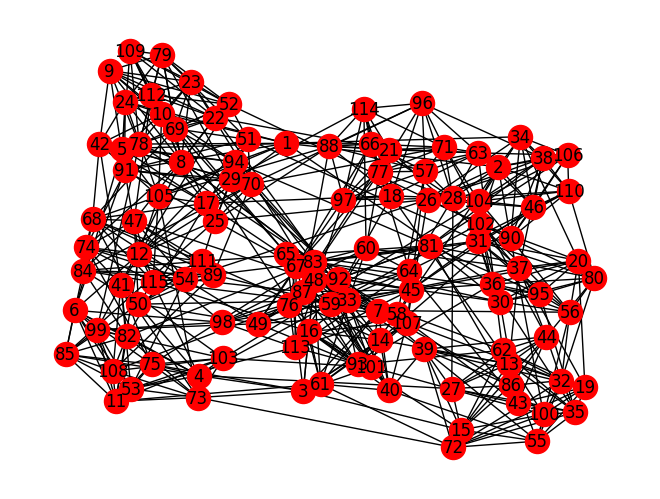

NMI:  0.9045844555728669
Modularity:  0.2416724104436502


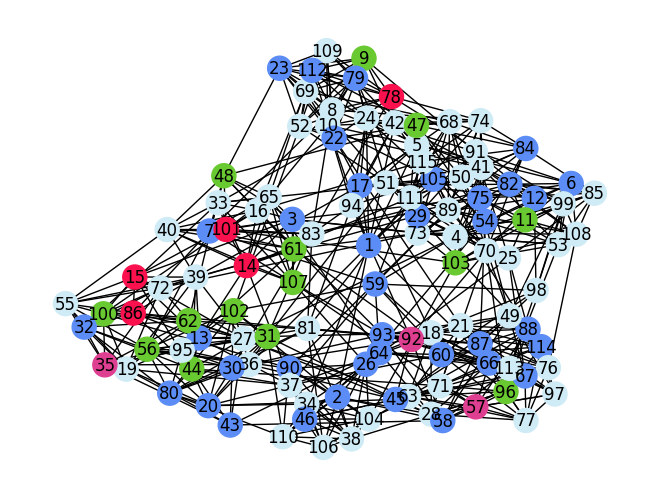

[[1, 2, 5, 10, 17, 24, 34, 42, 66, 91, 94, 26, 38, 46, 90, 104, 106, 110, 14, 59, 103, 70, 86, 112, 13, 18, 19, 37, 96, 97, 114, 43, 64, 81, 92, 60, 89], [80, 95, 76, 36, 49, 87, 93, 58, 102, 56, 20, 30, 31, 45], [73, 108, 105], [63, 27, 57, 35, 28], [3, 4, 7, 15, 16, 48, 61, 65, 75, 101, 107, 6, 12, 41, 53, 82, 85, 29, 109, 11, 98, 99, 8, 33, 40, 9, 22, 23, 69, 74, 78, 79, 83, 52, 25, 51, 39, 44, 111, 55, 72, 100, 115, 68, 21, 88, 32, 62, 71, 77, 47, 67, 54, 50, 113, 84]]


In [29]:
import networkx as nx
import numpy as np
import pandas as pd

import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt

import math



def community_detection(nodes,edges,population=15,generation=30,r=1.5):
    
    graph=nx.Graph() 
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph) 
   
    nodes_length = len(graph.nodes())
    nx.draw(graph, with_labels=True,node_color = "red")
    plt.show()
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
      
    dframe = pd.DataFrame(data= d)
    
    
    dframe["f_score"]=dframe.apply(lambda x: f_score(x["chrom"],r,Adj),axis=1)
    completeData = pd.DataFrame(data=dframe)
    gen = 0
    population_count = population
    k=population
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            
            elites = dframe.sort_values("f_score",ascending=False)[int(np.floor(population/10)):]
            best3 = dframe.sort_values("f_score", ascending=True)[0:3]
            xalpha = dframe.loc[best3.index[0]]['chrom']
            xbeta = dframe.loc[best3.index[1]]['chrom']
            xgamma = dframe.loc[best3.index[2]]['chrom']
            a = 2*(1-(gen/generation))
            
            for index , wolf in elites.iterrows():
                A1 = (2*a*np.random.rand()) - a
                C1 = 2*np.random.rand()
                Dalpha = abs(C1*xalpha - wolf['chrom'])
                X1 = abs(xalpha - (A1*Dalpha))
                
                A2 = (2*a*np.random.rand()) - a
                C2 = 2*np.random.rand()
                Dbeta = abs(C2*xbeta - wolf['chrom'])
                X2 = abs(xbeta - (A2*Dbeta))
                
                A3 = (2*a*np.random.rand()) - a
                C3 = 2*np.random.rand()
                Dgamma = abs(C3*xgamma - wolf['chrom'])
                X3 = abs(xgamma - (A3*Dgamma))
                
                Xnew = (X1+X2+X3)/3
                Xnew = np.array([int(i) for i in Xnew])
                for i in range(0,len(Xnew)):
                    if Xnew[i] < 0 or Xnew[i] >= Adj.shape[0] or Adj[i,Xnew[i]]==0:
                        Xnew[i] = xalpha[i]
                fscorenew = f_score(Xnew, r, Adj)
                
                
                
                dframe.loc[population_count]=[Xnew,fscorenew]
                population_count += 1
                
                completeData.loc[k]=[Xnew,fscorenew]
                k += 1
            
            
            
        dfsorted = dframe.sort_values("f_score",ascending=True)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1   
    sorted_df = dframe.sort_values("f_score",ascending=True).index[0]
    res = dframe.loc[sorted_df]
    
    
    
    res = res['chrom']
    
    istrue = check_res(res,Adj)
    
    res_subsets = find_subsets(res)
    
    nodes_subsets = res_subsets
    nodes_list = list(graph.nodes())
    result = []
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        result.append(subset)
    NMI = 0
    clu = dframe.loc[sorted_df]
    clu = clu['chrom']
    clu = np.array(clu)
    for index, target in completeData.iterrows():
        temp = np.array(target['chrom'])
        x = computeNMI(clu,temp)
        NMI += x
    NMI /= len(completeData)
    modularity = nx_comm.modularity(graph, result)
    print("NMI: ", NMI)
    print("Modularity: ", modularity)
    print_graph(graph, result, nodes)
    return result
def entropy(nums):
    z = np.bincount(nums)
    N = len(nums)
    assert nums.shape == (N, )
    ent = 0.0
    for e in z:
        if e != 0:
            p = float(e) / N
            ent += p*math.log(p)
    assert ent <= 0
    ent = -ent

    assert ent >=0
    return ent
def computeNMI(clusters, classes):

    assert clusters.shape == classes.shape
    A = np.c_[(clusters, classes)]
    A = np.array(A)
    N = A.shape[0]
    assert A.shape == (N, 2)

    H_clusters = entropy(A[:, 0])
    H_classes = entropy(A[:, 1])
    NMI = 0.0
    for k in np.unique(A[:, 0]):
        # get elements in second column that have first column equal to j
        z = A[A[:, 0] == k, 1]
        len_wk = len(z)
        t = A[:, 1]
        #for each unique class in z
        for e in np.unique(z):
            wk_cj=len(z[z==e])
            len_cj=len(t[t == e])
            assert wk_cj <= len_cj
            numerator= (float(wk_cj) / float(N)) * math.log( (N*wk_cj) / float(len_wk * len_cj)  )
            NMI += numerator
    NMI /= float((H_clusters + H_classes) * 0.5)
    assert (NMI > 0.0 or abs(NMI) < 1e-10) and (NMI < 1.0 or abs(NMI - 1.0) < 1e-10)
    return NMI
def check_res(res,Adj):
    for i in range(0,len(res)):
        if Adj[i,res[i]] ==0:
            return False
    return True
# returning the the array of column indexes where randomly chosen till value is 1 
def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom



def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(result):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    return result

def f_score(chrom,r,Adj):
    score = 0
    for i in chrom:
        score += i*i;
    score /= len(chrom)
    return score

        
    



def print_graph(graph, result, nodes):
    colors = []
    for i in range(0, len(result)):
        colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))
    col_arr = ['']*len(nodes)
    for i in range(0,len(result)):
        for j in result[i]:
            col_arr[j-1] = colors[i]
    nx.draw(graph, with_labels=True,node_color = col_arr)
    plt.show()
    
    
        
            
















nodes = []
edges = np.loadtxt('football.txt')
for i in edges:
    for j in i:
        if j not in nodes:
            nodes.append(int(j))
    

arr = community_detection(nodes,edges)


print(arr)


#nx.draw_networkx_nodes(graph, arr[0], node_color="tab:blue")